# Lab 5 - Big Data Visualization

## 1. Handling Volume of Big Data
In this section, you will explore how to handling the volume of big data by sampling. First we will load the synthetic 2-D data poitns by scikit-learn.

Note: we need to install the following **imbalanced-learn** package:
```python
conda install imbalanced-learn
```
or
```python
pip install imbalanced-learn
```

In [172]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from imblearn.datasets import make_imbalance
%matplotlib inline
import math

Now you will visualize the dataset. Complete the code marked with TODO

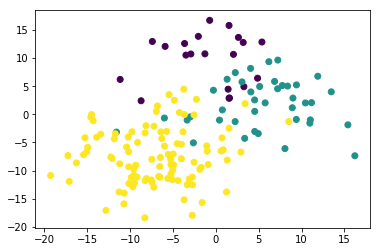

In [33]:
"""
Generate random 2D data points
"""
def gen_data(num_samples,num_blobs=3,random_state=42):
    X, y = make_blobs(n_samples=num_samples, random_state=random_state, centers=num_blobs, cluster_std=5.0)
    return X,y

rseed = 42
num_samples = 300
num_blobs   = 3
X,y = gen_data(num_samples, num_blobs, rseed)
ratio = {0: 20, 1: 40, 2: 100}
X,y = make_imbalance(X, y, sampling_strategy=ratio)

plt.scatter(*zip(*X), c=y)
plt.show()

### 1.1. Simple Random Sampling (SRS)
Now we implement the first sampling method, called Simple Random Smapling (SRS). In this method, there is an equal probability of selecting any particular item. Complete the code marked with TODO.

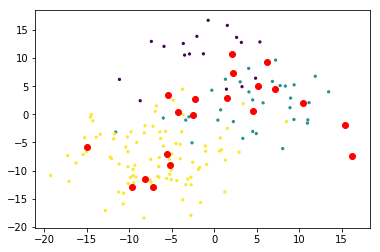

In [34]:
def srs(points, k=10):
    return random.sample(list(points), k)

np.random.seed(30)
sample = srs(X, 20)

# Visualize the sample
_ = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
_ = plt.scatter(*zip(*sample), c='red')
plt.show()

### 1.2. Stratified Sampling
Now we will explore another sampling method, called stratified sampling. This method comprises of two steps:

1. Split the data into several partitions. We will use the label information for this purpose
2. Draw random samples from each partition. For simplicity, we make the stratified random samples of the same size.

Complete the code marked with TODO

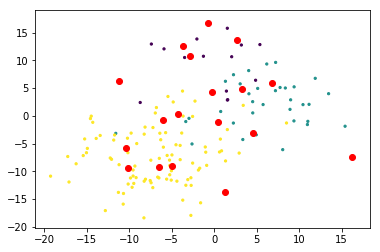

In [84]:
from functools import reduce

def stratified_sampling(points, cluster_labels, n_clusters=3, k=10):
    cluster_samples = []
    n = int(k/3)
    # COMPLETE perform SRS on each cluster by reusing the srs function
    for label in np.unique(cluster_labels):
        label_points = points[cluster_labels==label] 
        cluster_samples.append(srs(label_points, n))
        

    # Append the stratified samples into the whole sampling data
    sample = reduce((lambda x,y: x+y), cluster_samples)
    print("\n\n")
    return np.array(sample)

# np.random.seed(30)
sample = stratified_sampling(X, y, num_blobs, 20)
_ = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
_ = plt.scatter(sample[:, 0], sample[:, 1], c='red')

Now we want to improve stratified sampling such that:
+ The stratified random samples are not of the same size but proportion to the size of clusters
+ Each cluster has at least one sampling points

Complete the code marked with TODO 

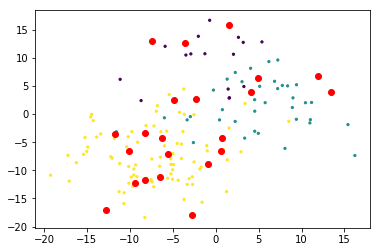

In [164]:
def hybrid_sampling(points, cluster_labels, n_clusters=3, k=10):    
    # COMPLETE we want to make sure that each cluster has at least one sampling point
    fixed_points = []
    for label in np.unique(cluster_labels):
        label_points = points[cluster_labels==label] 
        fixed_points += (srs(label_points, 1))
    fixed_points = np.array(fixed_points)
    
    # COMPLETE we do sampling on the remaining points so that the stratified random samples are proportion to the size of clusters
    remain_points = [p for p in points.tolist() if p not in fixed_points]
    extra_points = []
    for label in np.unique(cluster_labels):
        count = list(cluster_labels).count(label)
        proportion = count/len(cluster_labels)
        extra_points += srs(remain_points, int(k*proportion))
    extra_points = np.array(extra_points)
    
    return(np.concatenate((fixed_points, extra_points)))

# np.random.seed(30)
sample = hybrid_sampling(X, y, num_blobs, 20)
# print(sample)

_ = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
_ = plt.scatter(sample[:, 0], sample[:, 1], c='red')

## 2. Handling the Variety of Big Data
In this section, we are going to implement a diversification algorithm, namely Motley, in the lecture. We reuse the dataset in the previous section. First, we are going to define the relevance of each data item by using the data label in ground truth and generating a random number around the mean equal to label value. Note that the color bar indicates the relevance degree.

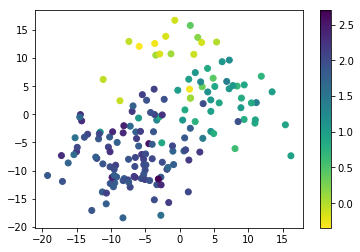

In [189]:
def relevance(X, y, random_seed=42):
    rel = [0] * len(X)
    for i in range(len(X)):
        rel[i] = np.random.normal(y[i],0.2)
    return rel

relev = relevance(X,y)
_ = plt.scatter(X[:, 0], X[:, 1], c=relev, cmap='viridis_r')
_ = plt.colorbar()

### 2.1. Similarity function
We will implement the dissimilarity function by using Euclidean distance. Complete the code marked with TODO.

In [190]:
def distance_matrix(points):
    n = len(points)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # TODO compute the Euclidean distance
            M[i,j] = math.sqrt( (points[i,0]-points[j,0])**2 + (points[i,1]-points[j,1])**2)
    return M
M = distance_matrix(X)
M

array([[ 0.        ,  6.77412714,  6.65074156, ..., 35.8976955 ,
        23.06028365, 22.07884985],
       [ 6.77412714,  0.        ,  5.54048529, ..., 29.30484854,
        17.37631893, 15.62213901],
       [ 6.65074156,  5.54048529,  0.        , ..., 30.82742771,
        17.00159331, 20.01188641],
       ...,
       [35.8976955 , 29.30484854, 30.82742771, ...,  0.        ,
        15.14908355, 18.97284906],
       [23.06028365, 17.37631893, 17.00159331, ..., 15.14908355,
         0.        , 16.48417141],
       [22.07884985, 15.62213901, 20.01188641, ..., 18.97284906,
        16.48417141,  0.        ]])

### 2.2. Motley algorithm
The Motley algorithm constructs the output by incrementally adding items in the decreasing order of relevance and maximizing the minimum dissimilarity.
+ Traverse items in the decreasing order of relevance
+ Add an item to output if the dissimilarity with other selected items is larger than a threshold $\Delta$

Complete the code marked with TODO 

7.184749937832262
[[ -5.89380762  12.07266757]
 [  1.44596211   4.46734885]
 [  3.20491645  12.77395129]
 [ -8.69395118   2.41200306]
 [  8.07117979  -6.09040967]
 [ 11.89559688   6.76952381]
 [ -2.60054287  -5.06414919]
 [ 15.40579112  -1.86356813]
 [-15.2266536   -4.16330863]
 [ -2.73259929 -17.93578614]]


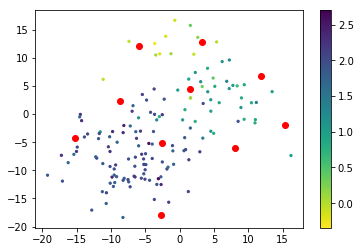

In [205]:
def motley(points, relev, M, delta, k =10):
    points_index = range(len(points))
    # COMPLETE: sort the points by decreasing order of relevance
        
    points_sorted_by_relevance = [x for _,x in sorted(zip(relev, points_index))]
    
    # TODO: the main of Motley algorithm
    S = []
    print(delta)
    for p in points_sorted_by_relevance:
        min_dissimularity = math.inf
        for s in S:
            if M[p,s] < min_dissimularity:
                min_dissimularity = M[p,s]
        if min_dissimularity > delta:
            S.append(p)
    return points[S[:k]]

# We will take threshold as 20% of the maximum distance between any two points
delta = 0.2 * np.amax(M)

# The retain set of data items that are both relevant and diverse among themselves
retain = motley(X, relev, M, delta)
print(retain)
_ = plt.scatter(X[:, 0], X[:, 1], c=relev, s=5, cmap='viridis_r')
_ = plt.colorbar()
_ = plt.scatter(retain[:, 0], retain[:, 1], c='red')